<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/bamboo_forest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sliding Window Combined with CNN for Bamboo forest detection

**Using deep learning for bamboo forest detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

In [2]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Download dataset

In [3]:
## Download and extract dataset
!wget https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip bamboo.zip
!unzip -P bamboo bamboo.zip

--2019-01-20 13:03:46--  https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28240432 (27M) [application/zip]
Saving to: ‘bamboo.zip’

bamboo.zip          100%[===================>]  26.93M   118MB/s    in 0.2s    

2019-01-20 13:03:48 (118 MB/s) - ‘bamboo.zip’ saved [28240432/28240432]

--2019-01-20 13:03:48--  http://bamboo.zip/
Resolving bamboo.zip (bamboo.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘bamboo.zip’
FINISHED --2019-01-20 13:03:48--
Total wall clock time: 2.0s
Downloaded: 1 files, 27M in 0.2s (118 MB/s)
Archive:  bamboo.zip
   creating: bamboo/
   creating: bamboo/test/
  inflating: bamboo/test/test_image.png  
   creating: bamboo/train/
  inf

## Preview

In [9]:
!ls bamboo/train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

b10.png  b13.png  b2.png  b5.png  b8.png   o1.png  o4.png  o7.png
b11.png  b14.png  b3.png  b6.png  b9.png   o2.png  o5.png  o8.png
b12.png  b1.png   b4.png  b7.png  o10.png  o3.png  o6.png  o9.png


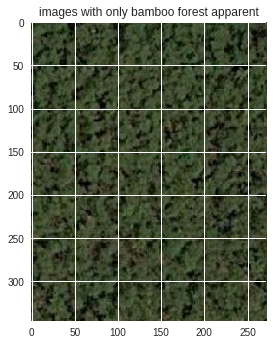

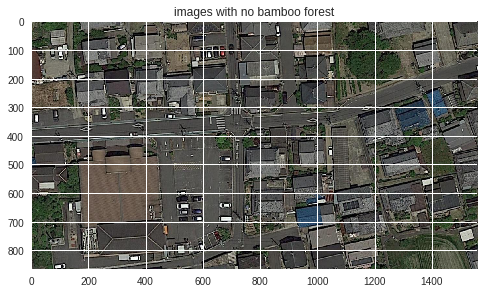

In [10]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


# Create "chopped" subimages from each image using a sliding window

In [0]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

In [0]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(3492, 56, 56, 3) (3492,)


In [0]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(2793, 56, 56, 3)
(2793,)
(699, 56, 56, 3)
(699,)


In [0]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([ 700, 2093]))
(array([0, 1]), array([175, 524]))
[1.995      0.66722408]


# Build and Train CNN

In [0]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
__________

In [0]:
history = model.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),class_weight=cw)

Train on 2793 samples, validate on 699 samples
Epoch 1/10
2793/2793 [==============================] - 2s 615us/step - loss: 0.4438 - acc: 0.7780 - val_loss: 0.2591 - val_acc: 0.9027
Epoch 2/10
2793/2793 [==============================] - 1s 404us/step - loss: 0.2573 - acc: 0.9048 - val_loss: 0.2721 - val_acc: 0.8827
Epoch 3/10
2793/2793 [==============================] - 1s 403us/step - loss: 0.1444 - acc: 0.9588 - val_loss: 0.3979 - val_acc: 0.8383
Epoch 4/10
2793/2793 [==============================] - 1s 411us/step - loss: 0.1148 - acc: 0.9696 - val_loss: 0.2483 - val_acc: 0.9142
Epoch 5/10
2793/2793 [==============================] - 1s 408us/step - loss: 0.1087 - acc: 0.9706 - val_loss: 0.0810 - val_acc: 0.9843
Epoch 6/10
2793/2793 [==============================] - 1s 408us/step - loss: 0.0951 - acc: 0.9717 - val_loss: 0.0714 - val_acc: 0.9857
Epoch 7/10
2793/2793 [==============================] - 1s 412us/step - loss: 0.0832 - acc: 0.9728 - val_loss: 0.0729 - val_acc: 0.9871
E

# Evaluate against Test Data

In [0]:
#try against test data

img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255

windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)

n_total = len(windows)

#sliding windowの横幅を確認
_x = 0

for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x

print(n_total,n_x,n_total//n_x)

37
2405 37 65


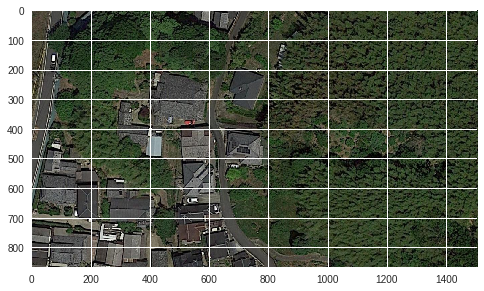

In [0]:
plt.imshow(img)

In [0]:
patches = []

for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)
print(patches.shape)

(2405, 56, 56, 3)


(2405, 1)
[[0.34087396]
 [0.35757962]
 [0.37594298]
 ...
 [0.00152864]
 [0.002535  ]
 [0.00544888]]


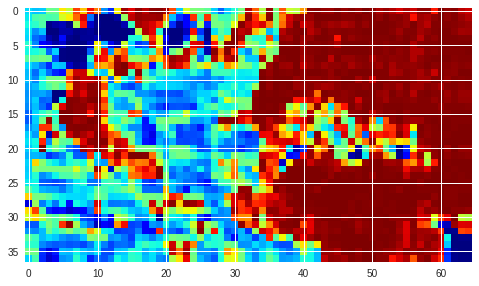

In [0]:
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

In [0]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


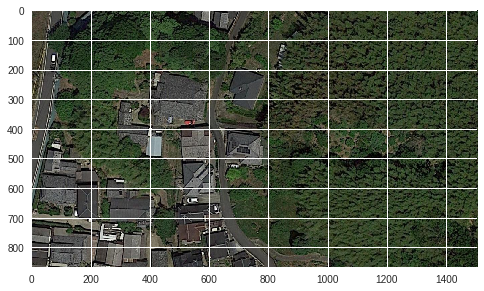

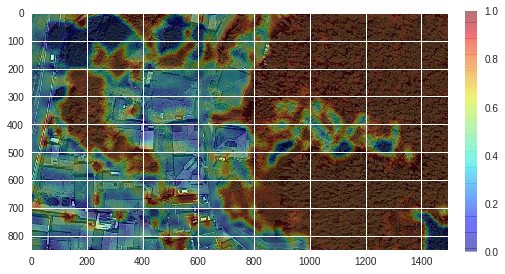

In [0]:
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()